# Аналитика в Яндекс.Афише

Меня пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

У меня в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
-	лог сервера с данными о посещениях сайта Яндекс.Афиши,
-	выгрузка всех заказов за этот период,
-	статистика рекламных расходов.

Необходимо изучить:
-	как люди пользуются продуктом,
-	когда они начинают покупать,
-	сколько денег приносит каждый клиент
-	когда клиент окупается.


### План работы:
1. Загрузить данные и подготовить их к анализу
2. Построить отчёты и посчитать метрики

Продукт
    - сколько людей пользуются в день, неделю, месяц;
    - сколько сессий в день;
    - сколько длится одна сессия;
    - как часто люди возвращаются.
    
Продажи
    - когда люди начинают покупать;
    - сколько раз покупают за период;
    - какой средний чек;
    - сколько денег приносят (LTV).
    
Маркетинг
    - сколько денег потратили (всего / на каждый источник / по времени);
    - сколько стоило привлечение одного покупателя из каждого источника;
    - на сколько окупились расходы (ROI).
Отобразить на графиках, как эти метрики отличаются по устройствам и по рекламным источникам и как они меняются во времени.
3. Написать вывод: порекомендовать маркетологам, куда и сколько им стоит вкладывать денег.

Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?


### Шаг 1.  Загружаем данные и готовим их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

#### Таблица visits (лог сервера с информацией о посещениях сайта)

In [5]:
path = 'D:\яндекс практикум\резюме\мои проекты\indicators'
visits = pd.read_csv(path + '\isits_log.csv')

In [6]:
'''Переименуем названия столбцов таблицы visits'''
visits = visits.rename(columns={'Device': 'device', 'End Ts' : 'end_ts', 'Source Id': 'source_id', 'Start Ts': 'start_ts', 'Uid': 'uid'})

'''Поменяем тип данных в столбце end_ts и start_ts и выделим месяц из обоих столбцов'''
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['end_ts_month'] = visits['end_ts'].astype('datetime64[M]')

visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')

display(visits.head(20))
print(visits.info())
display(visits['start_ts'].describe())
print('Проверяем количество пропущенных значений')
print(visits.isnull().sum())
print()
print('Количество дублирующих записей в таблице visits равно', visits.duplicated().sum())



,device,end_ts,source_id,start_ts,uid,end_ts_month,start_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-01
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-01,2017-09-01
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-01,2018-01-01
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-01,2017-11-01
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-01,2017-07-01
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-01,2017-11-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   device          359400 non-null  object        
 1   end_ts          359400 non-null  datetime64[ns]
 2   source_id       359400 non-null  int64         
 3   start_ts        359400 non-null  datetime64[ns]
 4   uid             359400 non-null  uint64        
 5   end_ts_month    359400 non-null  datetime64[ns]
 6   start_ts_month  359400 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(1), uint64(1)
memory usage: 19.2+ MB
None


count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

Проверяем количество пропущенных значений
device            0
end_ts            0
source_id         0
start_ts          0
uid               0
end_ts_month      0
start_ts_month    0
dtype: int64

Количество дублирующих записей в таблице visits равно 0


#### Описание таблицы visits (лог сервера с информацией о посещениях сайта):
-	uid — уникальный идентификатор пользователя
-	device — категория устройства пользователя
-	start_ts — дата и время начала сессии
-	end_ts — дата и время окончания сессии
-	source_id — идентификатор рекламного источника, из которого пришел пользователь


In [7]:
orders = pd.read_csv(path + '\orders_log.csv')

In [8]:
'''Переименуем названия столбцов таблицы orders'''
orders = orders.rename(columns={'Buy Ts' : 'buy_ts', 'Revenue': 'revenue', 'Uid': 'uid'})

'''Поменяем тип данных в столбце buy_ts и выделим месяц из столбца'''
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['buy_ts_month'] = orders['buy_ts'].astype('datetime64[M]')

display(orders.head(20))
print(orders.info())

print('Проверяем количество пропущенных значений')
print(orders.isnull().sum())
print()
print(orders['buy_ts'].describe())
print()
print('Количество дублирующих записей в таблице orders равно', orders.duplicated().sum())



,buy_ts,revenue,uid,buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   buy_ts        50415 non-null  datetime64[ns]
 1   revenue       50415 non-null  float64       
 2   uid           50415 non-null  uint64        
 3   buy_ts_month  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.5 MB
None
Проверяем количество пропущенных значений
buy_ts          0
revenue         0
uid             0
buy_ts_month    0
dtype: int64

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Количество дублирующих записей в таблице orders равно 0


#### Описание таблицы orders (информация о заказах):
-	uid — уникальный id пользователя, который сделал заказ
-	buy_ts — дата и время заказа
-	revenue — выручка Яндекс.Афиши с этого заказа


In [9]:
costs = pd.read_csv(path + '\costs.csv')

In [10]:
'''Поменяем тип данных в столбце dt и выделим месяц из столбца'''
costs['dt'] = pd.to_datetime(costs['dt'])
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

display(costs.head(20))
print(costs.info())
print(costs['dt'].describe())
print()
print('Проверяем количество пропущенных значений')
print(costs.isnull().sum())
print()
print('Количество дублирующих записей в таблице costs равно', costs.duplicated().sum())

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
5,1,2017-06-06,40.39,2017-06-01
6,1,2017-06-07,40.59,2017-06-01
7,1,2017-06-08,56.63,2017-06-01
8,1,2017-06-09,40.16,2017-06-01
9,1,2017-06-10,43.24,2017-06-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
 3   dt_month   2542 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 79.6 KB
None
count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Проверяем количество пропущенных значений
source_id    0
dt           0
costs        0
dt_month     0
dtype: int64

Количество дублирующих записей в таблице costs равно 0


#### Описание таблицы costs (информация о затратах на маркетинг):
-	source_id — идентификатор рекламного источника
-	dt — дата
-	costs — затраты на этот рекламный источник в этот день

### Вывод

Данные чистые, пропущенные значения и дубликаты отсутствуют. Изменены названия столбцов.

### Шаг 2.  Строим отчёты и считаем метрики

In [11]:
'''Посчитаем сколько людей пользуются в день, неделю, месяц на основе данных таблицы visits'''

'''Выделим из start_ts дату, неделю и год'''
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['year'] = visits['start_ts'].dt.year

'''Посчитаем метрики DAU, WAU и MAU'''
dau_visits = visits.groupby('date').agg({'uid': 'nunique'})
wau_visits = visits.groupby(['year', 'week']).agg({'uid': 'nunique'})
mau_visits = visits.groupby(['year', 'start_ts_month']).agg({'uid': 'nunique'})

print('Среднее количество посещений сайта пользователями за период сбора данных:')
print('в день -', int(dau_visits.mean()))
print('в неделю -', int(wau_visits.mean()))
print('в месяц -', int(mau_visits.mean()))

sticky_factor_wau = int(dau_visits.mean()) / int(wau_visits.mean()) 
sticky_factor_mau = int(dau_visits.mean()) / int(mau_visits.mean()) 
print('Регулярность пользования сайтом sticky_wau {:.2%}, sticky_mau {:.2%}'.format(sticky_factor_wau, sticky_factor_mau))    

Среднее количество посещений сайта пользователями за период сбора данных:
в день - 907
в неделю - 5716
в месяц - 23228
Регулярность пользования сайтом sticky_wau 15.87%, sticky_mau 3.90%


In [12]:
dau_visits.head(20)

,uid
date,
2017-06-01,605
2017-06-02,608
2017-06-03,445
2017-06-04,476
2017-06-05,820
2017-06-06,797
2017-06-07,699
2017-06-08,868
2017-06-09,695


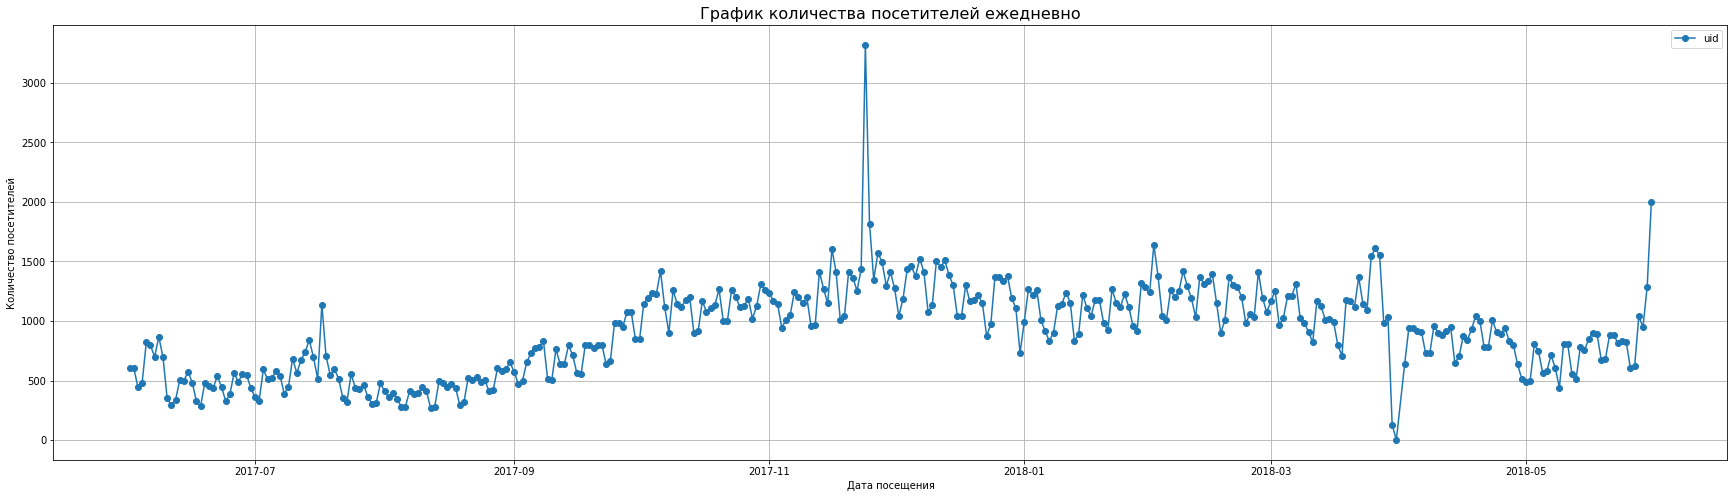

In [13]:
dau_visits = dau_visits.reset_index()

dau_visits.plot(x='date', y='uid', style='o-', figsize=(30,8), grid=True)
plt.title('График количества посетителей ежедневно', fontdict={'size':16})
plt.xlabel('Дата посещения')
plt.ylabel('Количество посетителей');

In [14]:
wau_visits = wau_visits.reset_index()


In [15]:
wau_visits['week'] = wau_visits['week'].astype('str')
wau_visits['year'] = wau_visits['year'].astype('str')
wau_visits['year_and_week'] = wau_visits['year'] + '_year_and week_no_' + wau_visits['week']

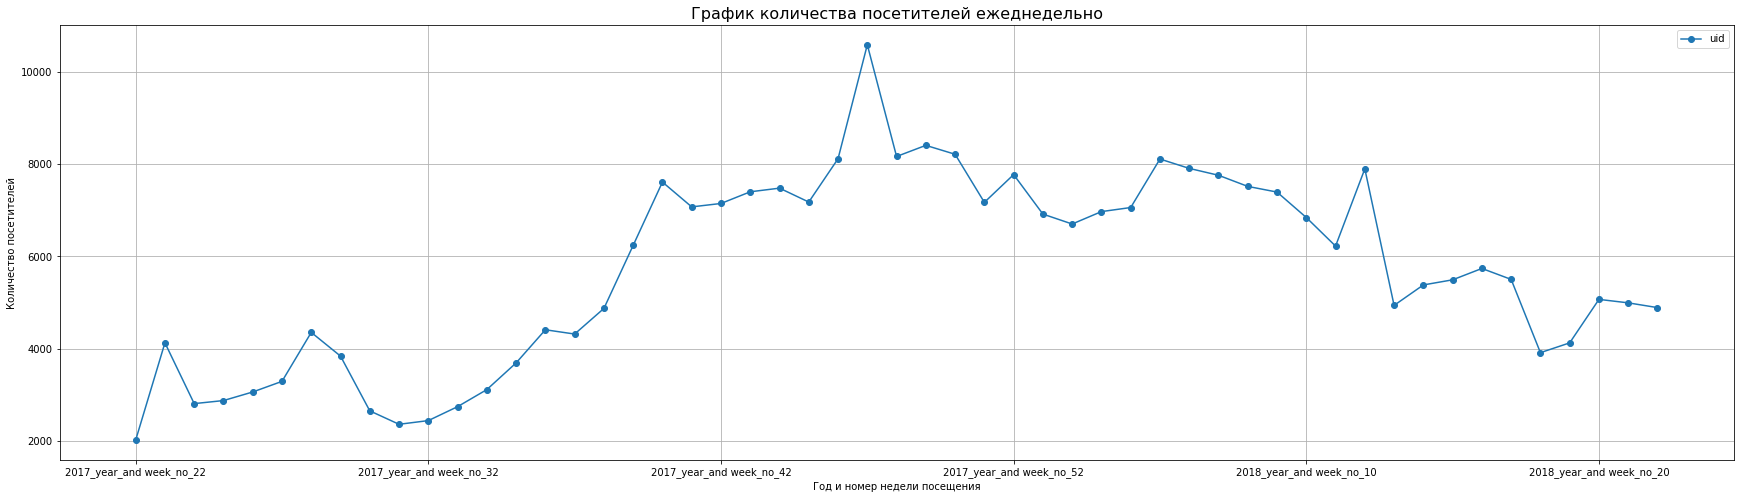

In [16]:
wau_visits.plot(x='year_and_week', y='uid', style='o-', figsize=(30,8), grid=True)
plt.title('График количества посетителей ежеднедельно', fontdict={'size':16})
plt.xlabel('Год и номер недели посещения')
plt.ylabel('Количество посетителей');

In [17]:
mau_visits = mau_visits.reset_index()

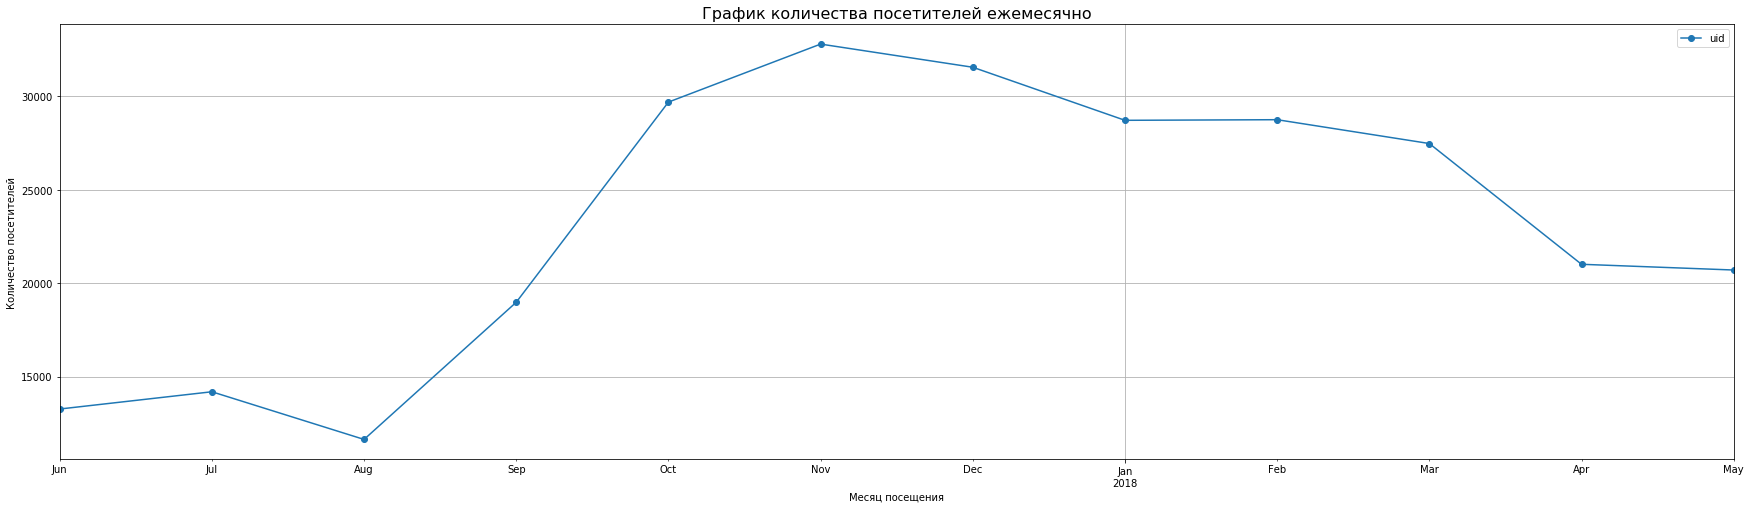

In [18]:
mau_visits.plot(x='start_ts_month', y='uid', style='o-', figsize=(30,8), grid=True)
plt.title('График количества посетителей ежемесячно', fontdict={'size':16})
plt.xlabel('Месяц посещения')
plt.ylabel('Количество посетителей');

### Вывод

Среднее количество посещений сайта пользователями с 01.06.2017 по 01.06.2018:
в день - 907
в неделю - 5716
в месяц - 23228
Регулярность пользования сайтом sticky_wau 15.87%, sticky_mau 3.90%

Количество посетителей сайта с августа 2017 года значительно выросло и достигло пика в ноябре и далее наблюдается снижение. Считаю, что нужно выяснить какие изменения в продукт были внесены в период роста и спада количества посетителей, был ли рост сезонным.

### Посчитаем среднее количество сессий на одного посетителя в день и среднюю продолжительность сессии

Среднее количество сессий на одного посетителя в день 1.08


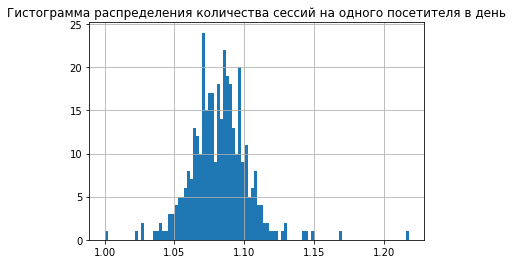

In [19]:
sessions_per_user = visits.groupby('date').agg({'uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

plt.title('Гистограмма распределения количества сессий на одного посетителя в день')
sessions_per_user['sessions_per_user'].hist(bins=100)
print('Среднее количество сессий на одного посетителя в день {:.2f}'.format(sessions_per_user['sessions_per_user'].mean()))

In [20]:
sessions_per_user.head(10)

,n_sessions,n_users,sessions_per_user
date,,,
2017-06-01,664,605,1.10
2017-06-02,658,608,1.08
2017-06-03,477,445,1.07
2017-06-04,510,476,1.07
2017-06-05,893,820,1.09
2017-06-06,875,797,1.10
2017-06-07,788,699,1.13
2017-06-08,939,868,1.08
2017-06-09,755,695,1.09


В связи с тем, что распределение продолжительности сессий не нормально, примем за ASL значение моды продолжительности сессий: 0    60
dtype: int64


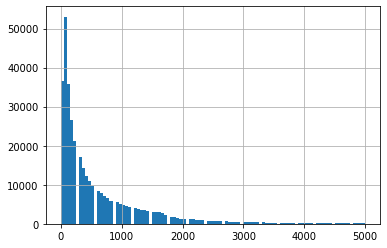

In [21]:
'''Выясним среднюю продолжительность сессии посетителя'''

visits['visit_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits['visit_duration'].hist(bins=100, range=(0, 5000))
print('В связи с тем, что распределение продолжительности сессий не нормально, примем за ASL значение моды продолжительности сессий:', visits['visit_duration'].mode())


### Вывод

В среднем посетитель заходит на сайт один раз в день и проводит на сайте 1 минуту.


### Рассчитаем как часто пользователи возвращаются (retention rate)

In [22]:
visits.head(10)

,device,end_ts,source_id,start_ts,uid,end_ts_month,start_ts_month,date,week,year,visit_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-01,2017-12-20,51,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-01,2018-02-19,8,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-07-01,26,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-01,2018-05-20,20,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-01,2017-12-27,52,2017,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-01,2017-09-01,2017-09-03,35,2017,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-01,2018-01-01,2018-01-30,5,2018,3360
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-01,2017-11-01,2017-11-05,44,2017,60
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-01,2017-07-01,2017-07-19,29,2017,180
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-01,2017-11-01,2017-11-08,45,2017,60


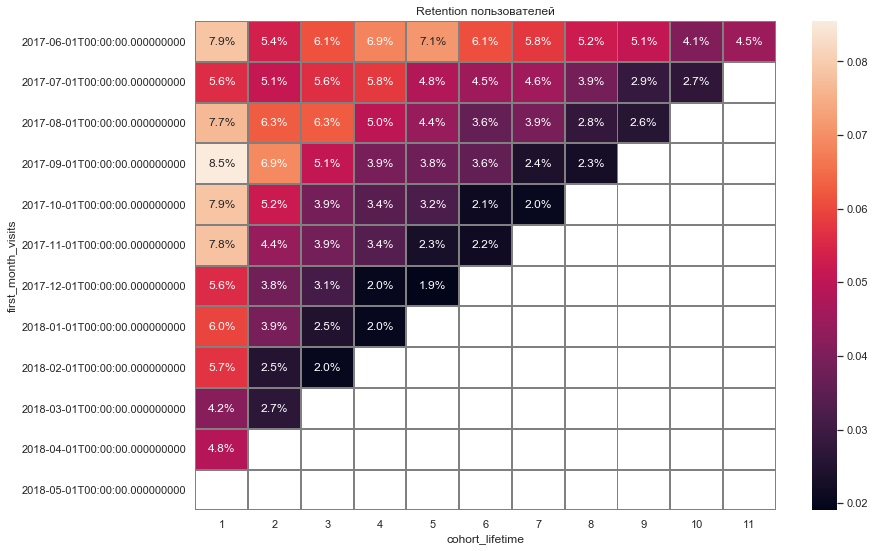

In [23]:
visits_first_month = visits.groupby('uid')['start_ts_month'].min().reset_index()
visits_first_month.columns = ['uid', 'first_month_visits']
visits = visits.merge(visits_first_month, on='uid', how='left')
visits['cohort_lifetime'] = (visits['start_ts_month'] - visits['first_month_visits']) / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
cohorts = visits.groupby(['first_month_visits', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users = cohorts[cohorts['cohort_lifetime'] == 0][['first_month_visits','uid']]
initial_users.columns = ['first_month_visits', 'n_visitors']

cohorts = cohorts.merge(initial_users, on='first_month_visits')

#cohorts['first_month_visits'] = cohorts['first_month_visits'].dt.strftime('%m-%Y') # меняем тип данных, чтобы на тепловой карте нормально даты отображались
cohorts['retention'] = cohorts['uid'] / cohorts['n_visitors']
retention_pivot = cohorts.pivot_table(index='first_month_visits', columns='cohort_lifetime', values='retention', aggfunc='mean')



'''Строим тепловую карту retention'''

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention пользователей')

sns.heatmap(retention_pivot.drop(columns=[0]), annot=True, fmt='.1%', linewidths=1, linecolor='gray');

In [24]:
cohorts

,first_month_visits,cohort_lifetime,uid,n_visitors,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.04
74,2018-03-01,2,557,20589,0.03
75,2018-04-01,0,15709,15709,1.00
76,2018-04-01,1,760,15709,0.05


In [25]:
'''Средний уровень retention для когорт когда lifetime равен 1 (второй месяц жизни)'''
cohort_life1_mean = cohorts[cohorts['cohort_lifetime'] == 1][['retention']].mean()
print('Средний уровень retention для когорт на втором месяце {:.1%}'.format(cohort_life1_mean.mean()))

Средний уровень retention для когорт на втором месяце 6.5%


In [26]:
cohorts

,first_month_visits,cohort_lifetime,uid,n_visitors,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,1043,13259,0.08
2,2017-06-01,2,713,13259,0.05
3,2017-06-01,3,814,13259,0.06
4,2017-06-01,4,909,13259,0.07
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.04
74,2018-03-01,2,557,20589,0.03
75,2018-04-01,0,15709,15709,1.00
76,2018-04-01,1,760,15709,0.05


### Вывод

Из тепловой карты разпределения по когортам retention rate пользователей можно сделать вывод, что retention rate низкий. Начиная с декабря 2017 года retention rate еще сильнее снижается.

Думаю необходимо обратить внимание на данную метрику и нацелить маркетинговую политику компании на возврат посетителей для повторных покупок. 

Средний уровень retention для когорт на втором месяце жизни когорты равен 6.1%

### Продажи
    - когда люди начинают покупать;
    - сколько раз покупают за период;

### Через сколько времени после первого посещения люди начинают покупать?

In [27]:
'''Когда люди начинают покупать'''
visits_first_date = visits.groupby('uid')['date'].min().reset_index()
visits_first_date.columns = ['uid', 'first_date_visit']

In [28]:
visits.head(20)

,device,end_ts,source_id,start_ts,uid,end_ts_month,start_ts_month,date,week,year,visit_duration,first_month_visits,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-01,2017-12-20,51,2017,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-01,2018-02-19,8,2018,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-07-01,26,2017,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-01,2018-05-20,20,2018,1440,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-01,2017-12-27,52,2017,0,2017-12-01,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-01,2017-09-01,2017-09-03,35,2017,60,2017-09-01,0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-01,2018-01-01,2018-01-30,5,2018,3360,2017-06-01,7
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-01,2017-11-01,2017-11-05,44,2017,60,2017-11-01,0
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-01,2017-07-01,2017-07-19,29,2017,180,2017-07-01,0
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-01,2017-11-01,2017-11-08,45,2017,60,2017-11-01,0


In [29]:
orders['date'] = orders['buy_ts'].dt.date
orders_first_date = orders.groupby('uid')['date'].min().reset_index()
orders_first_date.columns = ['uid', 'first_date_order']
when_order = orders_first_date.merge(visits_first_date, on='uid')
when_order['how_long_to_order'] = when_order['first_date_order'] - when_order['first_date_visit']
when_order['how_long_to_order_months'] = (when_order['first_date_order'] - when_order['first_date_visit']) / np.timedelta64(1, 'M')
when_order['how_long_to_order_months'] = when_order['how_long_to_order_months'].round().astype('int')
print(when_order['how_long_to_order_months'].median())
print(when_order['how_long_to_order'].mode())
print(when_order['how_long_to_order_months'].mean())
print(when_order['how_long_to_order'].mean())

0.0
0   0 days
dtype: timedelta64[ns]
0.5414670207814254
16 days 21:30:05.864797


In [30]:
when_order

,uid,first_date_order,first_date_visit,how_long_to_order,how_long_to_order_months
0,313578113262317,2018-01-03,2017-09-18,107 days,4
1,1575281904278712,2017-06-03,2017-06-03,0 days,0
2,2429014661409475,2017-10-11,2017-10-11,0 days,0
3,2464366381792757,2018-01-28,2018-01-27,1 days,0
4,2551852515556206,2017-11-24,2017-11-24,0 days,0
...,...,...,...,...,...
36518,18445147675727495770,2017-11-24,2017-08-20,96 days,3
36519,18445407535914413204,2017-09-22,2017-09-22,0 days,0
36520,18445601152732270159,2018-03-26,2017-08-07,231 days,8
36521,18446156210226471712,2018-02-18,2017-11-07,103 days,3


### Вывод

В основном люди совершают покупку в момент первого визита на сайт.

### Сколько покупок совершает пользователь

In [31]:
display(orders.head(20))


,buy_ts,revenue,uid,buy_ts_month,date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01


Среднее количество покупок на одного пользователя равно 1.38


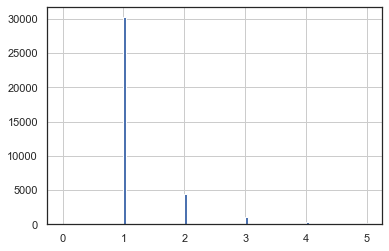

In [32]:
orders_per_buyer = orders.groupby('uid')['date'].count()
orders_per_buyer.hist(bins=100, range=(0,5))
print('Среднее количество покупок на одного пользователя равно {:.2f}'.format(orders_per_buyer.mean()))

In [33]:
orders.head(10)

,buy_ts,revenue,uid,buy_ts_month,date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01


In [34]:
'''Посчитаем сколько раз покупают за период'''
'''Возьмем период 4 месяцев'''

orders_first_month = orders.groupby('uid')['buy_ts_month'].min().reset_index().rename(columns={'buy_ts_month': 'order_first_month'})
orders = orders.merge(orders_first_month, on='uid')
orders['cohort_lifetime'] = ((orders['buy_ts_month'] - orders['order_first_month']) / np.timedelta64(1,'M')).round().astype('int')
cohort_orders = orders.groupby(['order_first_month', 'cohort_lifetime']).agg({'uid': ['count', 'nunique']}).reset_index()
cohort_orders.columns = ['first_order_month', 'cohort_lifetime', 'n_orders', 'nunique']
cohort_orders_four_month = cohort_orders.query('cohort_lifetime < 5')
cohort_orders_four_month = cohort_orders_four_month.query('first_order_month <= "2017-12-01"')

display(cohort_orders_four_month.pivot_table(index='first_order_month', columns='cohort_lifetime', values='n_orders', aggfunc='mean'))

orders_four_month = cohort_orders_four_month.groupby('first_order_month')['n_orders'].sum()
print('Количество заказов покупателей разных когорт за 4 месяца')
display(orders_four_month)
print()
print('Среднее количество заказов покупателей разных когорт за 4 месяца: {:.0f} заказа'.format(orders_four_month.mean()))

cohort_lifetime,0,1,2,3,4
first_order_month,,,,,
2017-06-01,2354,177,174,226,292
2017-07-01,2186,100,120,104,72
2017-08-01,1533,108,100,81,85
2017-09-01,2933,219,161,164,67
2017-10-01,4964,314,162,122,129
2017-11-01,4813,397,182,211,136
2017-12-01,5052,270,202,179,86


Количество заказов покупателей разных когорт за 4 месяца


first_order_month
2017-06-01    3223
2017-07-01    2582
2017-08-01    1907
2017-09-01    3544
2017-10-01    5691
2017-11-01    5739
2017-12-01    5789
Name: n_orders, dtype: int64


Среднее количество заказов покупателей разных когорт за 4 месяца: 4068 заказа


### Вывод

Среднее количество покупок на одного пользователя равно 1,38.

Количество заказов с каждой новой когортой увеличивается. Резко возросло количество заказов, начиная с октября 2017 года.

Среднее количество заказов покупателей разных когорт за 4 месяца - 4068 заказа

Средний чек покупателей за период с июня 2017 по конец мая 2018 года 4.09 ден. единицы


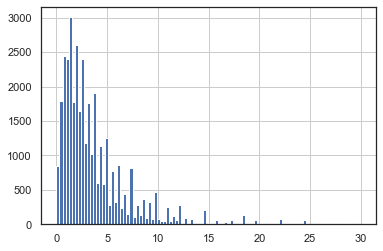

In [35]:
'''Считаем средний чек'''

mean_check = orders.groupby('uid').agg({'revenue': 'sum', 'date': 'count'}).reset_index().rename(columns={'date': 'orders_number'})
mean_check['mean_check'] = mean_check['revenue'] / mean_check['orders_number']
mean_check['mean_check'].hist(bins=100, range=(0, 30))
print('Средний чек покупателей за период с июня 2017 по конец мая 2018 года {:.2f} ден. единицы'.format(mean_check['mean_check'].mean()))

In [36]:
mean_check.head(10)

,uid,revenue,orders_number,mean_check
0,313578113262317,0.55,1,0.55
1,1575281904278712,3.05,2,1.52
2,2429014661409475,73.33,1,73.33
3,2464366381792757,2.44,1,2.44
4,2551852515556206,10.99,2,5.50
5,3077748354309989,4.67,1,4.67
6,3605148382144603,0.69,3,0.23
7,3753586865891862,3.50,1,3.50
8,4808417689019433,1.22,1,1.22
9,4992223027560440,3.05,1,3.05


### Вывод

Средний чек покупателей за период с июня 2017 по конец мая 2018 года 4.09 ден. единицы

### Считаем LTV

In [37]:
orders.head(10)

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01,0
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01,0
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-05,2017-06-01,0
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01,0
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-02,2017-06-01,0


In [38]:
first_order_month = orders.groupby('uid')['buy_ts_month'].min()
first_order_month.name = 'first_order_month'
orders = orders.join(first_order_month, on='uid')

cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns=['first_order_month', 'n_buyers']

In [39]:
orders.head(10)

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-05,2017-06-01,0,2017-06-01
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-02,2017-06-01,0,2017-06-01


In [40]:
orders_ltv = orders.merge(cohort_sizes, on='first_order_month')

In [41]:
orders_ltv.head(10)

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime,first_order_month,n_buyers
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-05,2017-06-01,0,2017-06-01,2023
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2023
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-02,2017-06-01,0,2017-06-01,2023


In [42]:
cohorts_ltv = orders_ltv.groupby(['first_order_month', 'buy_ts_month', 'n_buyers']).agg({'revenue': 'sum'}).reset_index()
'''Предположим что маржинальность заказов 100%'''
margin = 1
cohorts_ltv['gp'] =  cohorts_ltv['revenue'] * margin
cohorts_ltv['age'] = (cohorts_ltv['buy_ts_month'] - cohorts_ltv['first_order_month']) / np.timedelta64(1, 'M')
cohorts_ltv['age'] = cohorts_ltv['age'].round().astype('int')
cohorts_ltv['ltv'] = cohorts_ltv['gp'] / cohorts_ltv['n_buyers']

In [43]:
cohorts_ltv.head(10)

,first_order_month,buy_ts_month,n_buyers,revenue,gp,age,ltv
0,2017-06-01,2017-06-01,2023,"9,557.49","9,557.49",0,4.72
1,2017-06-01,2017-07-01,2023,981.82,981.82,1,0.49
2,2017-06-01,2017-08-01,2023,885.34,885.34,2,0.44
3,2017-06-01,2017-09-01,2023,"1,931.30","1,931.30",3,0.95
4,2017-06-01,2017-10-01,2023,"2,068.58","2,068.58",4,1.02
5,2017-06-01,2017-11-01,2023,"1,487.92","1,487.92",5,0.74
6,2017-06-01,2017-12-01,2023,"1,922.74","1,922.74",6,0.95
7,2017-06-01,2018-01-01,2023,"1,176.56","1,176.56",7,0.58
8,2017-06-01,2018-02-01,2023,"1,119.15","1,119.15",8,0.55
9,2017-06-01,2018-03-01,2023,"1,225.51","1,225.51",9,0.61


In [44]:
cohorts_ltv_pivot = cohorts_ltv.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')

In [45]:
cohorts_ltv_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,nan
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,nan,nan
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,nan,nan,nan
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,nan,nan,nan,nan
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,nan,nan,nan,nan,nan
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,nan,nan,nan,nan,nan,nan
2018-01-01,4.14,0.29,0.30,0.14,0.06,nan,nan,nan,nan,nan,nan,nan
2018-02-01,4.16,0.28,0.08,0.07,nan,nan,nan,nan,nan,nan,nan,nan


In [46]:
cohorts_ltv_pivot.cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,nan
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,nan,nan
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,nan,nan,nan
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,nan,nan,nan,nan
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,nan,nan,nan,nan,nan
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,nan,nan,nan,nan,nan,nan
2018-01-01,4.14,4.43,4.73,4.88,4.94,nan,nan,nan,nan,nan,nan,nan
2018-02-01,4.16,4.44,4.51,4.59,nan,nan,nan,nan,nan,nan,nan,nan


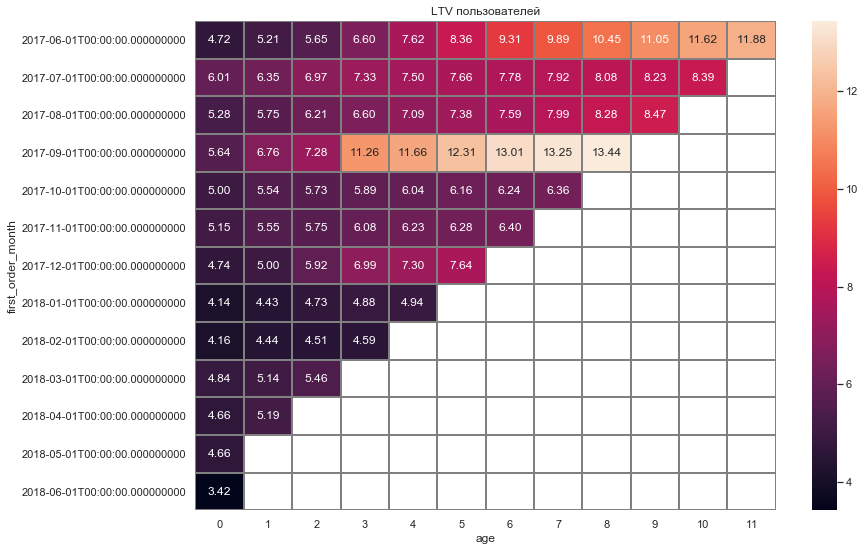

In [47]:
'''Строим тепловую карту LTV'''

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV пользователей')

sns.heatmap(cohorts_ltv_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

In [48]:
cohort20170601=cohorts_ltv[cohorts_ltv['first_order_month'] == '2017-06-01']['revenue'].sum()

In [49]:
cohort20170601

24031.690000000002

In [50]:
costs.head(15)

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
5,1,2017-06-06,40.39,2017-06-01
6,1,2017-06-07,40.59,2017-06-01
7,1,2017-06-08,56.63,2017-06-01
8,1,2017-06-09,40.16,2017-06-01
9,1,2017-06-10,43.24,2017-06-01


In [51]:
costs20170601 = costs[costs['dt_month'] == '2017-06-01']['costs'].sum()

In [52]:
costs20170601

18015.0

### Вывод

Из-за низкого retention rate основная доля LTV покупателей формируется при первой покупке.

## Маркетинг

- сколько денег потратили (всего / на каждый источник / по времени);
- сколько стоило привлечение одного покупателя из каждого источника;
- на сколько окупились расходы (ROI).

### Сколько денег потратили? Всего / на каждый источник / по времени

Всего потратили денег на привлечение клиентов за период с 1 июня 2017 года по 1 июня 2018 года 329131.62

Всего заработали денег за период с 1 июня 2017 года по 1 июня 2018 года 252057.20

Сколько всего потратили денег на каждый источник:


source_id
3    141,321.63
4     61,073.60
5     51,757.10
2     42,806.04
1     20,833.27
10     5,822.49
9      5,517.49
Name: costs, dtype: float64

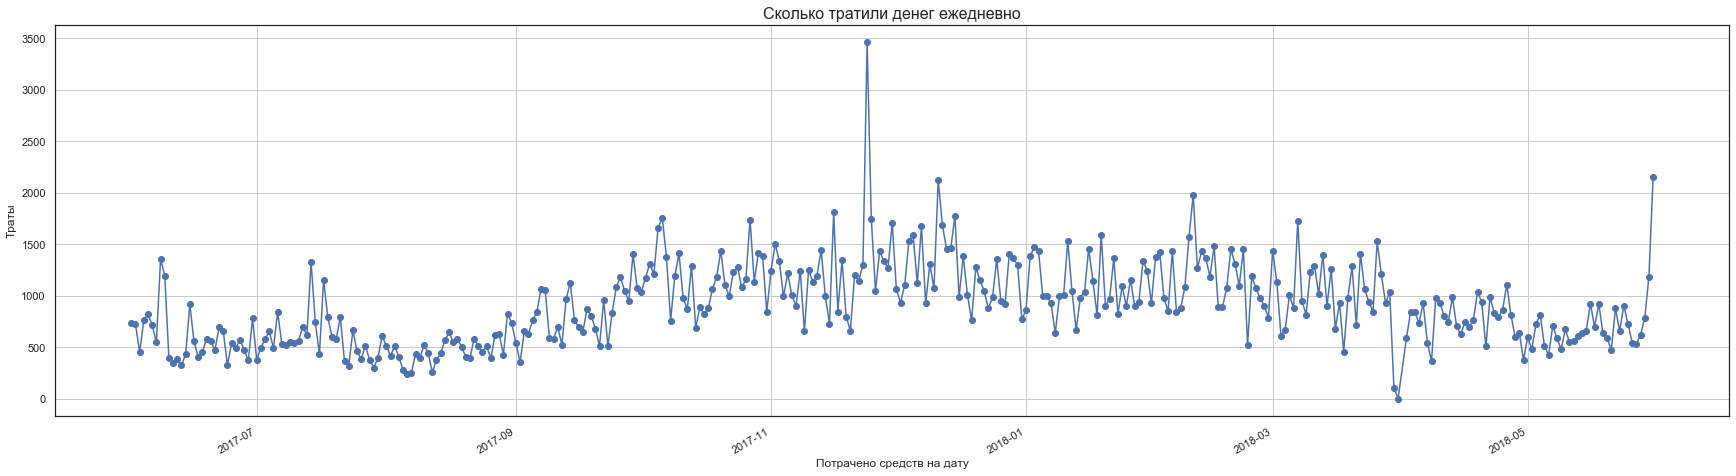

In [53]:
'''Сколько всего потратили денег'''
total_costs = costs['costs'].sum()
print('Всего потратили денег на привлечение клиентов за период с 1 июня 2017 года по 1 июня 2018 года', total_costs)
print()

'''Всего заработали денег за период с 1 июня 2017 года по 1 июня 2018 года'''

total_revenue = orders['revenue'].sum()
print('Всего заработали денег за период с 1 июня 2017 года по 1 июня 2018 года {:.2f}'.format(total_revenue))
print()

'''Сколько всего потратили денег на каждый источник'''

costs_per_source = costs.groupby('source_id')['costs'].sum().sort_values(ascending=False)

print('Сколько всего потратили денег на каждый источник:')
display(costs_per_source)

'''Сколько тратили денег ежедневно'''

costs_per_day = costs.groupby('dt')['costs'].sum()
costs_per_day.plot(x='dt', style='o-', figsize=(30,8), grid=True)
plt.title('Сколько тратили денег ежедневно', fontdict={'size':16})
plt.xlabel('Потрачено средств на дату')
plt.ylabel('Траты');


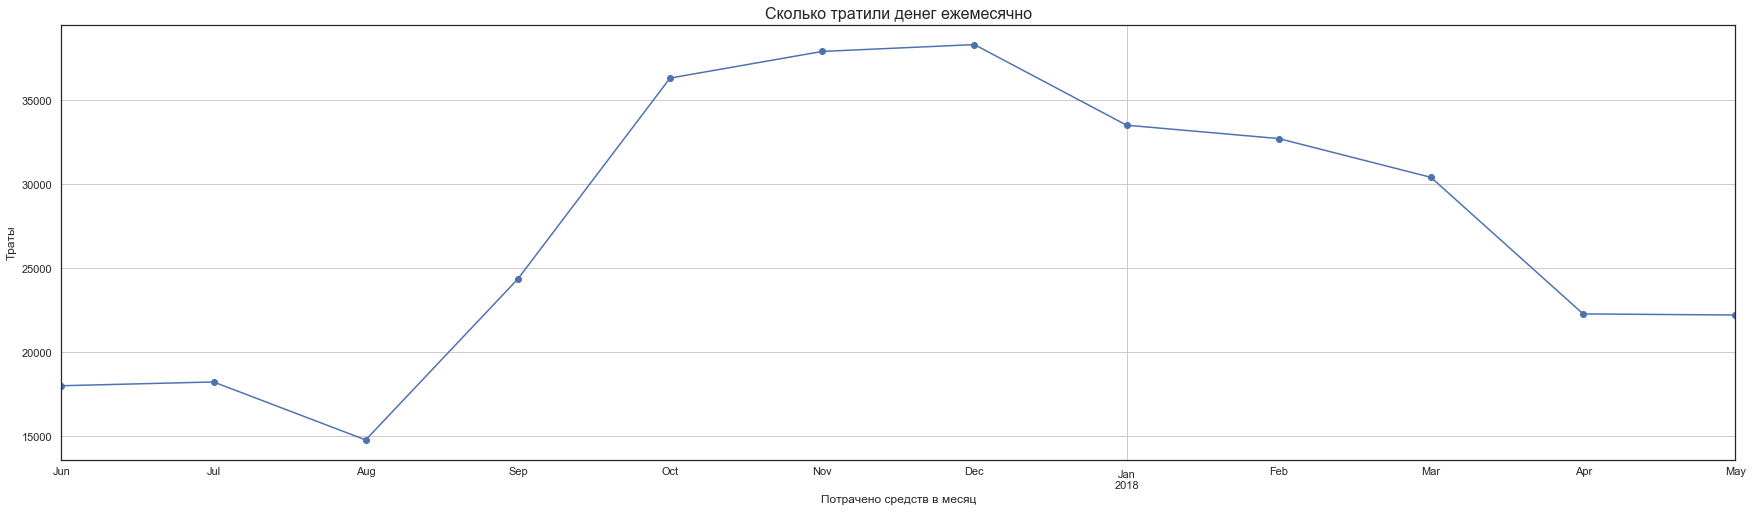

In [54]:
'''Сколько тратили денег ежемесячно'''

costs_per_month = costs.groupby('dt_month')['costs'].sum()
costs_per_month.plot(x='dt_month', style='o-', figsize=(30,8), grid=True)
plt.title('Сколько тратили денег ежемесячно', fontdict={'size':16})
plt.xlabel('Потрачено средств в месяц')
plt.ylabel('Траты');


In [55]:
print('Источники привлечения посетителей', costs['source_id'].unique())

Источники привлечения посетителей [ 1  2  3  4  5  9 10]


In [56]:
costs_per_month_pivot = costs.pivot_table(index='dt_month', columns='source_id', values='costs', aggfunc='sum')

In [57]:
costs_per_month_pivot

source_id,1,2,3,4,5,9,10
dt_month,,,,,,,
2017-06-01,"1,125.61","2,427.38","7,731.65","3,514.80","2,616.12",285.22,314.22
2017-07-01,"1,072.88","2,333.11","7,674.37","3,529.73","2,998.14",302.54,329.82
2017-08-01,951.81,"1,811.05","6,143.54","3,217.36","2,185.28",248.93,232.57
2017-09-01,"1,502.01","2,985.66","9,963.55","5,192.26","3,849.14",415.62,460.67
2017-10-01,"2,315.75","4,845.00","15,737.24","6,420.84","5,767.40",609.41,627.24
2017-11-01,"2,445.16","5,247.68","17,025.34","5,388.82","6,325.34",683.18,792.36
2017-12-01,"2,341.20","4,897.80","16,219.52","7,680.47","5,872.52",657.98,645.86
2018-01-01,"2,186.18","4,157.74","14,808.78","5,832.79","5,371.52",547.16,614.35
2018-02-01,"2,204.48","4,474.34","14,228.56","5,711.96","5,071.31",551.50,480.88


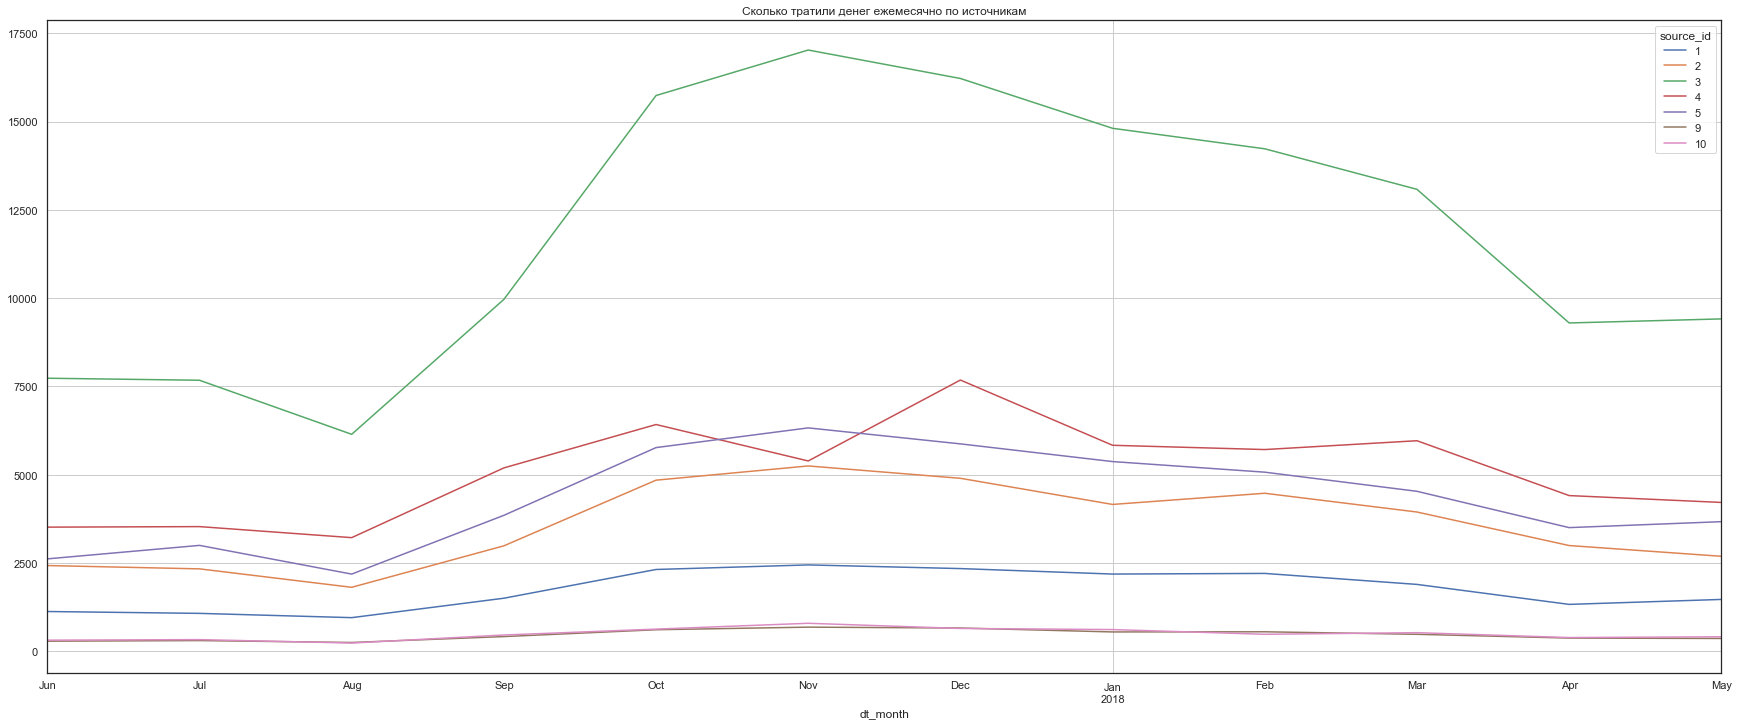

In [58]:
costs_per_month_pivot.plot(figsize=(30,12), grid=True, title='Сколько тратили денег ежемесячно по источникам');

### Вывод

Всего потратили на привлечение клиетов за период с 1 июня 2017 года по 1 июня 2018 года 329 131.62 ден. ед.

Всего заработали денег за период с 1 июня 2017 года по 1 июня 2018 года 252 057.20 ден. ед.

Т.е. можно сделать вывод, что бизнес пока не принес дохода.

Больше всего потрачено денег привлечение посетителей из источника 3, меньше всего на источник 9. Траты на источник 4, 5 и 2 соизмеримы друг с другом.

Источники:

    3    141,321.63

    4    61,073.60

    5    51,757.10

    2    42,806.04

    1    20,833.27

    10   5,822.49

    9    5,517.49

Графики трат на каждый источник не полностью, но в целом повторяют графики количества привлеченных посетителей во времени - увеличение трат с августа 2017 года, достижение пика в ноябре 2018 года и затем снижение до конца мая 2018 года.

Получается сколько денег потратишь столько и придет посетителей. Скорее всего основные траты это реклама (баннеры и т.д.).

Считаю необходимо развивать другие рекламные каналы кроме обычных. Например блог и социальные сети.



### Сколько стоило привлечение одного покупателя из каждого источника?

In [59]:
orders_date_min = orders.groupby('uid')['buy_ts'].min().astype('datetime64[D]')

In [60]:
orders_date_min.name = 'orders_first_date'
orders = orders.join(orders_date_min, on='uid')

In [61]:
orders

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime,first_order_month,orders_first_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31


In [62]:
users = visits.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]


In [63]:
users.head(10)

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
397399764396656,4
407573351275847,2
498809019029702,4
526778907996220,2


In [64]:
buyers = orders.join(users, on='uid')

In [65]:
buyers.head(10)

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime,first_order_month,orders_first_date,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,3
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,3
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,5
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-05,2017-06-01,0,2017-06-01,2017-06-01,5
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,1
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-02,2017-06-01,0,2017-06-01,2017-06-01,1


In [66]:
daily_buyers = buyers.groupby(['source_id', 'orders_first_date']).agg({'uid': 'count'}).reset_index().rename(columns={'uid': 'number_of_buyers'})

In [67]:
daily_buyers.head(10)

,source_id,orders_first_date,number_of_buyers
0,1,2017-06-01,278
1,1,2017-06-02,34
2,1,2017-06-03,240
3,1,2017-06-04,4
4,1,2017-06-05,357
5,1,2017-06-06,33
6,1,2017-06-07,24
7,1,2017-06-08,27
8,1,2017-06-09,21
9,1,2017-06-10,2


In [68]:
costs.head(10)

,source_id,dt,costs,dt_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
5,1,2017-06-06,40.39,2017-06-01
6,1,2017-06-07,40.59,2017-06-01
7,1,2017-06-08,56.63,2017-06-01
8,1,2017-06-09,40.16,2017-06-01
9,1,2017-06-10,43.24,2017-06-01


In [69]:
costs = costs.rename(columns={'dt': 'orders_first_date'})
daily_buyers_costs = daily_buyers.merge(costs, on=['source_id', 'orders_first_date'], how='left')

In [70]:
daily_buyers_costs['cac'] = daily_buyers_costs['costs'] / daily_buyers_costs['number_of_buyers']

In [71]:
daily_buyers_costs.head(10)

,source_id,orders_first_date,number_of_buyers,costs,dt_month,cac
0,1,2017-06-01,278,75.20,2017-06-01,0.27
1,1,2017-06-02,34,62.25,2017-06-01,1.83
2,1,2017-06-03,240,36.53,2017-06-01,0.15
3,1,2017-06-04,4,55.00,2017-06-01,13.75
4,1,2017-06-05,357,57.08,2017-06-01,0.16
5,1,2017-06-06,33,40.39,2017-06-01,1.22
6,1,2017-06-07,24,40.59,2017-06-01,1.69
7,1,2017-06-08,27,56.63,2017-06-01,2.10
8,1,2017-06-09,21,40.16,2017-06-01,1.91
9,1,2017-06-10,2,43.24,2017-06-01,21.62


In [72]:
'''Строим зависимость расходов на каждого покупателя в зависимости от источника'''

daily_buyers_costs_pivot = daily_buyers_costs.pivot_table(index='orders_first_date', columns='source_id', values='cac', aggfunc='mean')

In [73]:
daily_buyers_costs_pivot.head(15)

source_id,1,2,3,4,5,9,10
orders_first_date,,,,,,,
2017-06-01,0.27,2.55,6.59,4.80,3.05,1.00,15.08
2017-06-02,1.83,12.03,7.31,1.26,0.81,2.27,2.79
2017-06-03,0.15,8.58,13.07,4.24,0.80,3.53,1.20
2017-06-04,13.75,6.59,16.24,18.00,6.60,0.66,4.46
2017-06-05,0.16,0.63,5.59,1.14,6.27,1.70,2.43
2017-06-06,1.22,2.84,4.69,0.03,4.13,5.26,1.21
2017-06-07,1.69,4.03,2.42,0.92,2.68,nan,1.83
2017-06-08,2.10,6.00,8.98,9.16,5.79,1.51,0.55
2017-06-09,1.91,7.00,9.61,13.53,2.08,11.90,6.94


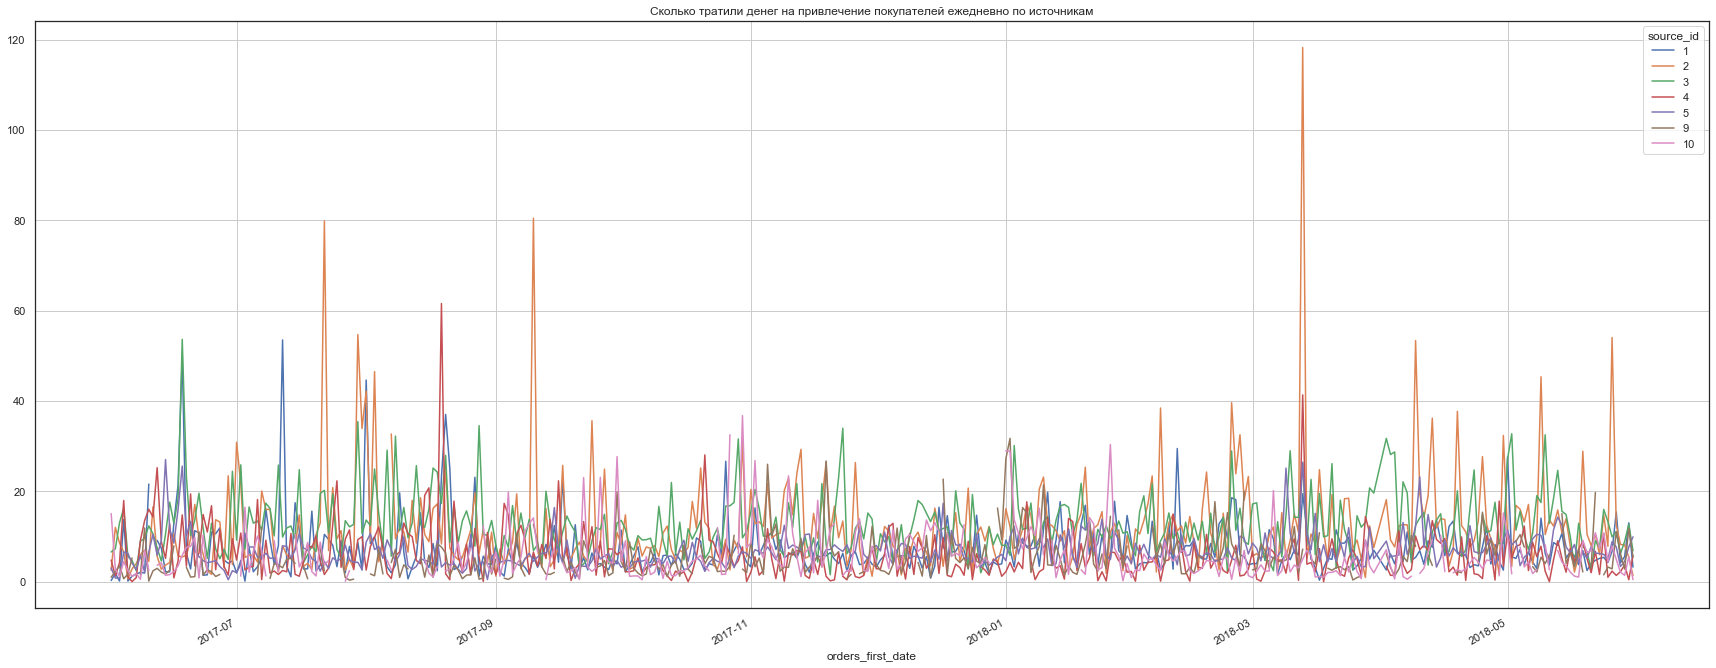

In [74]:
daily_buyers_costs_pivot.plot(figsize=(30,12), grid=True, title='Сколько тратили денег на привлечение покупателей ежедневно по источникам');

In [75]:
'''Строим зависимость расходов на каждого покупателя в зависимости от источника'''

daily_buyers_costs_month_pivot = daily_buyers_costs.pivot_table(index='dt_month', columns='source_id', values='cac', aggfunc='mean')

In [76]:
daily_buyers_costs_month_pivot

source_id,1,2,3,4,5,9,10
dt_month,,,,,,,
2017-06-01,7.98,7.30,12.28,8.66,7.20,3.16,4.22
2017-07-01,7.78,14.09,13.76,6.37,5.62,3.31,5.87
2017-08-01,9.95,13.69,16.30,8.92,5.26,3.54,5.37
2017-09-01,5.67,11.37,9.89,7.40,5.43,4.52,7.53
2017-10-01,6.08,9.25,11.39,4.90,4.88,3.93,5.80
2017-11-01,6.26,13.54,12.62,3.52,7.29,6.64,7.95
2017-12-01,6.19,8.69,10.53,4.68,6.70,6.10,7.35
2018-01-01,9.08,11.44,12.57,5.07,8.02,8.64,9.58
2018-02-01,8.48,15.33,11.73,4.65,6.61,7.29,4.17


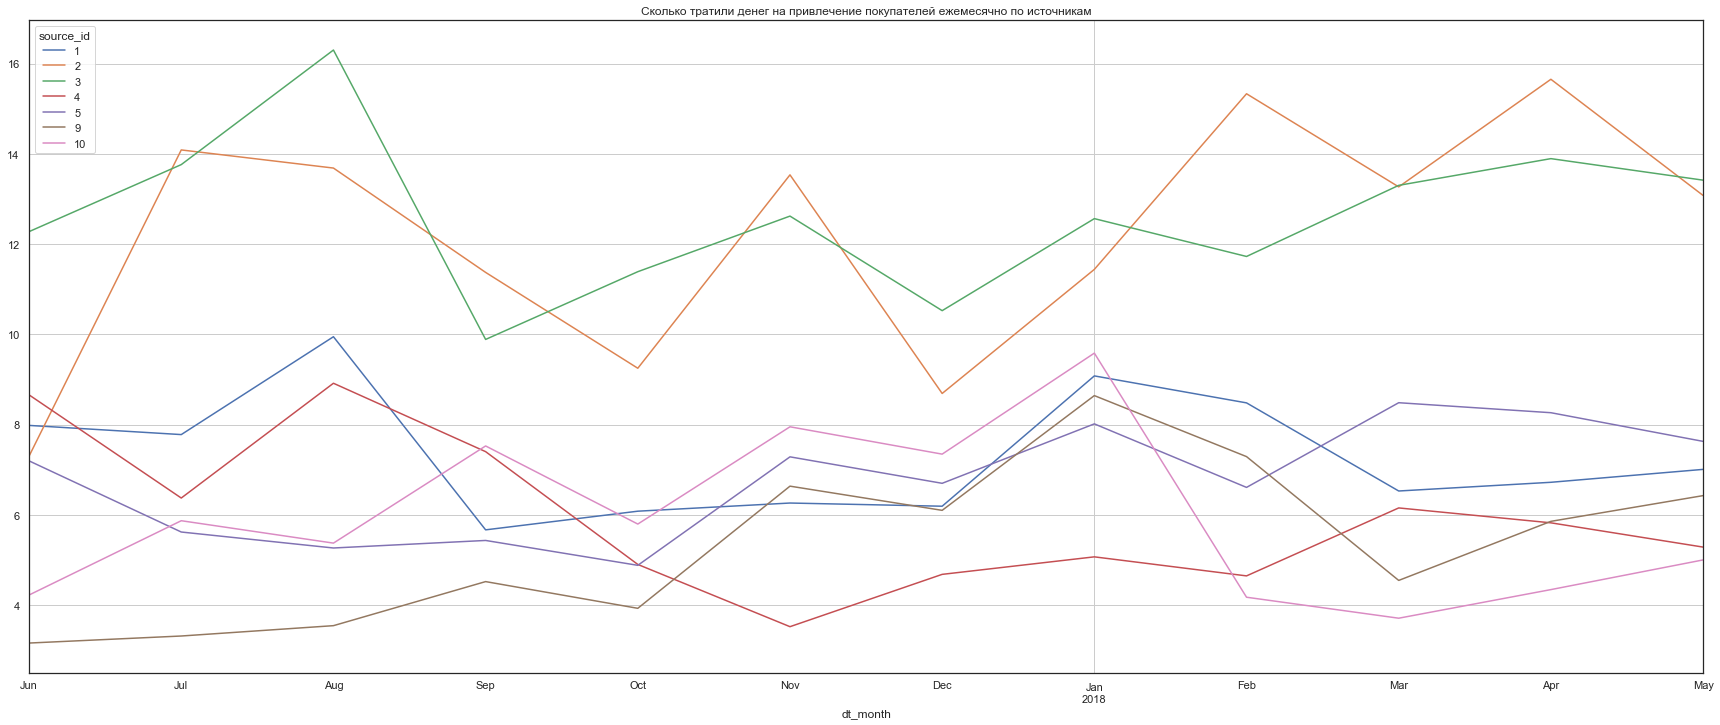

In [77]:
daily_buyers_costs_month_pivot.plot(figsize=(30,12), grid=True, title='Сколько тратили денег на привлечение покупателей ежемесячно по источникам');

### Вывод

Наибольшие затраты в расчете на одного покупателя приходятся на источники 3 и 2, меньше всего на 9, 10. Получается самые выгодные источники - 9, 10.

### Строим LTV и ROMI по источникам

In [78]:
orders['age'] = ((orders['buy_ts_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [79]:
orders

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime,first_order_month,orders_first_date,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0


In [80]:
users_ltv = visits.sort_values('start_ts').groupby('uid').agg({'source_id': 'first', 'device': 'first'})

In [81]:
buyers_ltv = orders.join(users_ltv, on='uid')

In [82]:
buyers_ltv

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime,first_order_month,orders_first_date,age,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,0,3,desktop
...,...,...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0,4,touch
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0,10,desktop
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0,3,desktop
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-31,2018-05-01,0,2018-05-01,2018-05-31,0,3,desktop


In [83]:
daily_buyers_ltv = buyers_ltv.groupby(['source_id', 'device', 'orders_first_date', 'first_order_month', 'age']).agg({'uid': 'count', 'revenue': 'sum'}).reset_index().rename(columns={'uid': 'number_of_buyers'})

In [84]:
daily_buyers_ltv

,source_id,device,orders_first_date,first_order_month,age,number_of_buyers,revenue
0,1,desktop,2017-06-01,2017-06-01,0,27,217.73
1,1,desktop,2017-06-01,2017-06-01,1,26,132.73
2,1,desktop,2017-06-01,2017-06-01,2,14,32.53
3,1,desktop,2017-06-01,2017-06-01,3,23,128.82
4,1,desktop,2017-06-01,2017-06-01,4,30,406.64
...,...,...,...,...,...,...,...
7930,10,touch,2018-05-24,2018-05-01,0,1,5.50
7931,10,touch,2018-05-25,2018-05-01,0,1,1.22
7932,10,touch,2018-05-28,2018-05-01,0,3,4.58
7933,10,touch,2018-05-30,2018-05-01,0,3,4.03


In [85]:
daily_buyer_costs_ltv = daily_buyers_ltv.merge(costs, on=['source_id', 'orders_first_date'], how='left')
daily_buyer_costs_ltv['ltv'] = daily_buyer_costs_ltv['revenue'] / daily_buyer_costs_ltv['number_of_buyers']
daily_buyer_costs_ltv['cac'] = daily_buyer_costs_ltv['costs'] / daily_buyer_costs_ltv['number_of_buyers']
daily_buyer_costs_ltv['romi'] = daily_buyer_costs_ltv['ltv'] / daily_buyer_costs_ltv['cac']

### Строим LTV и ROMI по устройствам

In [86]:
daily_buyer_costs_ltv

,source_id,device,orders_first_date,first_order_month,age,number_of_buyers,revenue,costs,dt_month,ltv,cac,romi
0,1,desktop,2017-06-01,2017-06-01,0,27,217.73,75.20,2017-06-01,8.06,2.79,2.90
1,1,desktop,2017-06-01,2017-06-01,1,26,132.73,75.20,2017-06-01,5.10,2.89,1.77
2,1,desktop,2017-06-01,2017-06-01,2,14,32.53,75.20,2017-06-01,2.32,5.37,0.43
3,1,desktop,2017-06-01,2017-06-01,3,23,128.82,75.20,2017-06-01,5.60,3.27,1.71
4,1,desktop,2017-06-01,2017-06-01,4,30,406.64,75.20,2017-06-01,13.55,2.51,5.41
...,...,...,...,...,...,...,...,...,...,...,...,...
7930,10,touch,2018-05-24,2018-05-01,0,1,5.50,10.79,2018-05-01,5.50,10.79,0.51
7931,10,touch,2018-05-25,2018-05-01,0,1,1.22,22.21,2018-05-01,1.22,22.21,0.05
7932,10,touch,2018-05-28,2018-05-01,0,3,4.58,21.26,2018-05-01,1.53,7.09,0.22
7933,10,touch,2018-05-30,2018-05-01,0,3,4.03,33.15,2018-05-01,1.34,11.05,0.12


In [87]:
daily_buyer_costs_device_ltv_pivot = daily_buyer_costs_ltv.pivot_table(index= 'device', columns='age', values='ltv', aggfunc='mean')

In [88]:
daily_buyer_costs_device_ltv_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,4.19,4.69,6.75,6.79,8.04,8.75,5.48,5.41,6.12,7.09,8.34,3.76
touch,3.81,4.45,4.06,4.64,4.38,4.47,6.46,7.49,3.24,5.27,4.02,7.79


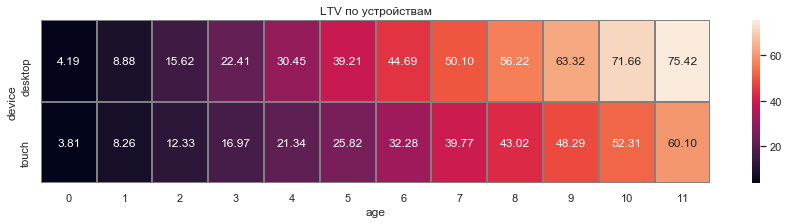

In [89]:
'''Строим тепловую карту LTV по устройствам'''

sns.set(style='white')
plt.figure(figsize=(15, 3))
plt.title('LTV по устройствам')

sns.heatmap(daily_buyer_costs_device_ltv_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

### Вывод

По результатам расчета LTV по устройствам получается, что пользователи, работающие на desktop приносят немного больше денег чем пользователи на touch.

In [90]:
daily_buyer_costs_device_romi_pivot = daily_buyer_costs_ltv.pivot_table(index= 'device', columns='age', values='romi', aggfunc='mean')

In [91]:
daily_buyer_costs_device_romi_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,0.92,0.21,0.26,0.65,0.32,0.87,1.12,0.44,0.48,2.14,3.93,0.17
touch,0.33,0.27,0.11,0.08,0.17,0.54,0.08,0.22,0.18,0.07,0.18,0.25


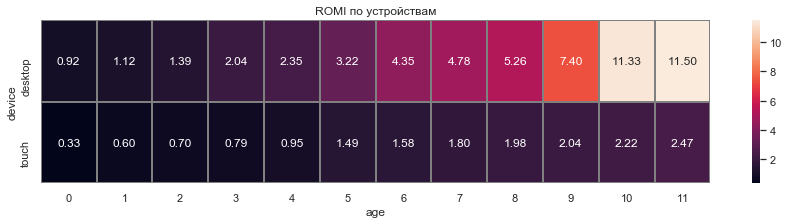

In [92]:
'''Строим тепловую карту ROMI по устройствам'''

sns.set(style='white')
plt.figure(figsize=(15, 3))
plt.title('ROMI по устройствам')

sns.heatmap(daily_buyer_costs_device_romi_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

### Вывод

По результатам расчета ROMI по устройствам получается, что необходимо сосредоточиться на источниках для desktop, а не touch. Пользователи, пришедшие из источников и устройства desktop окупаются на 2-й месяц, а пользователи на touch только на 6-й месяц.

In [93]:
daily_buyers_costs.head(10)

,source_id,orders_first_date,number_of_buyers,costs,dt_month,cac
0,1,2017-06-01,278,75.20,2017-06-01,0.27
1,1,2017-06-02,34,62.25,2017-06-01,1.83
2,1,2017-06-03,240,36.53,2017-06-01,0.15
3,1,2017-06-04,4,55.00,2017-06-01,13.75
4,1,2017-06-05,357,57.08,2017-06-01,0.16
5,1,2017-06-06,33,40.39,2017-06-01,1.22
6,1,2017-06-07,24,40.59,2017-06-01,1.69
7,1,2017-06-08,27,56.63,2017-06-01,2.10
8,1,2017-06-09,21,40.16,2017-06-01,1.91
9,1,2017-06-10,2,43.24,2017-06-01,21.62


In [94]:
buyers_costs = buyers.merge(daily_buyers_costs, on=['orders_first_date', 'source_id'], how='left')

In [95]:
buyers_costs.head(10)

,buy_ts,revenue,uid,buy_ts_month,date,order_first_month,cohort_lifetime,first_order_month,orders_first_date,source_id,number_of_buyers,costs,dt_month,cac
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,1,278,75.20,2017-06-01,0.27
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2,52,132.56,2017-06-01,2.55
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2,52,132.56,2017-06-01,2.55
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,2,52,132.56,2017-06-01,2.55
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,3,53,349.38,2017-06-01,6.59
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,3,53,349.38,2017-06-01,6.59
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,5,24,73.24,2017-06-01,3.05
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-05,2017-06-01,0,2017-06-01,2017-06-01,5,24,73.24,2017-06-01,3.05
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01,0,2017-06-01,2017-06-01,1,278,75.20,2017-06-01,0.27
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-02,2017-06-01,0,2017-06-01,2017-06-01,1,278,75.20,2017-06-01,0.27


In [96]:
buyers_costs_source_cohort = buyers_costs.groupby('source_id')['uid'].nunique().reset_index().rename(columns={'uid': 'cohort_source_size'})


In [97]:
buyers_costs_source_cohort

,source_id,cohort_source_size
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [98]:
cohorts_sources = buyers_costs.groupby(['source_id', 'buy_ts_month', 'first_order_month']).agg({'revenue': 'sum'}).reset_index()

In [99]:
cohorts_sources.head(10)

,source_id,buy_ts_month,first_order_month,revenue
0,1,2017-06-01,2017-06-01,"1,378.70"
1,1,2017-07-01,2017-06-01,414.98
2,1,2017-07-01,2017-07-01,"1,166.70"
3,1,2017-08-01,2017-06-01,419.43
4,1,2017-08-01,2017-07-01,175.31
5,1,2017-08-01,2017-08-01,846.75
6,1,2017-09-01,2017-06-01,714.24
7,1,2017-09-01,2017-07-01,856.74
8,1,2017-09-01,2017-08-01,135.29
9,1,2017-09-01,2017-09-01,"1,365.34"


In [100]:
buyers_costs_source_ltv = cohorts_sources.merge(buyers_costs_source_cohort, on='source_id')

In [101]:
buyers_costs_source_ltv.head(10)

,source_id,buy_ts_month,first_order_month,revenue,cohort_source_size
0,1,2017-06-01,2017-06-01,"1,378.70",2899
1,1,2017-07-01,2017-06-01,414.98,2899
2,1,2017-07-01,2017-07-01,"1,166.70",2899
3,1,2017-08-01,2017-06-01,419.43,2899
4,1,2017-08-01,2017-07-01,175.31,2899
5,1,2017-08-01,2017-08-01,846.75,2899
6,1,2017-09-01,2017-06-01,714.24,2899
7,1,2017-09-01,2017-07-01,856.74,2899
8,1,2017-09-01,2017-08-01,135.29,2899
9,1,2017-09-01,2017-09-01,"1,365.34",2899


In [102]:
buyers_costs_source_ltv['age'] = ((buyers_costs_source_ltv['buy_ts_month'] - buyers_costs_source_ltv['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')
margin = 1
buyers_costs_source_ltv['ltv'] = buyers_costs_source_ltv['revenue'] / buyers_costs_source_ltv['cohort_source_size']

In [103]:
buyers_costs_source_ltv.head(10)

,source_id,buy_ts_month,first_order_month,revenue,cohort_source_size,age,ltv
0,1,2017-06-01,2017-06-01,"1,378.70",2899,0,0.48
1,1,2017-07-01,2017-06-01,414.98,2899,1,0.14
2,1,2017-07-01,2017-07-01,"1,166.70",2899,0,0.40
3,1,2017-08-01,2017-06-01,419.43,2899,2,0.14
4,1,2017-08-01,2017-07-01,175.31,2899,1,0.06
5,1,2017-08-01,2017-08-01,846.75,2899,0,0.29
6,1,2017-09-01,2017-06-01,714.24,2899,3,0.25
7,1,2017-09-01,2017-07-01,856.74,2899,2,0.30
8,1,2017-09-01,2017-08-01,135.29,2899,1,0.05
9,1,2017-09-01,2017-09-01,"1,365.34",2899,0,0.47


In [104]:
buyers_costs_source_ltv_pivot = buyers_costs_source_ltv.pivot_table(index= 'source_id', columns='age', values='ltv', aggfunc='sum')

In [105]:
buyers_costs_source_ltv_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.24,0.92,0.79,0.73,0.40,0.25,0.26,0.37,0.33,0.19,0.13,0.11
2,6.61,1.42,1.61,1.61,0.70,0.53,0.37,0.20,0.13,0.07,0.11,0.03
3,4.49,0.27,0.15,0.10,0.07,0.05,0.03,0.02,0.02,0.01,0.00,0.00
4,4.56,0.19,0.10,0.13,0.10,0.11,0.17,0.04,0.02,0.04,0.05,0.00
5,4.84,0.25,0.21,1.50,0.20,0.24,0.13,0.09,0.05,0.07,0.01,0.01
7,1.22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,3.89,0.28,0.28,0.22,0.14,0.13,0.11,0.08,0.13,0.02,0.01,nan
10,3.16,0.07,0.03,0.04,0.02,0.01,0.01,0.01,0.00,0.00,nan,nan


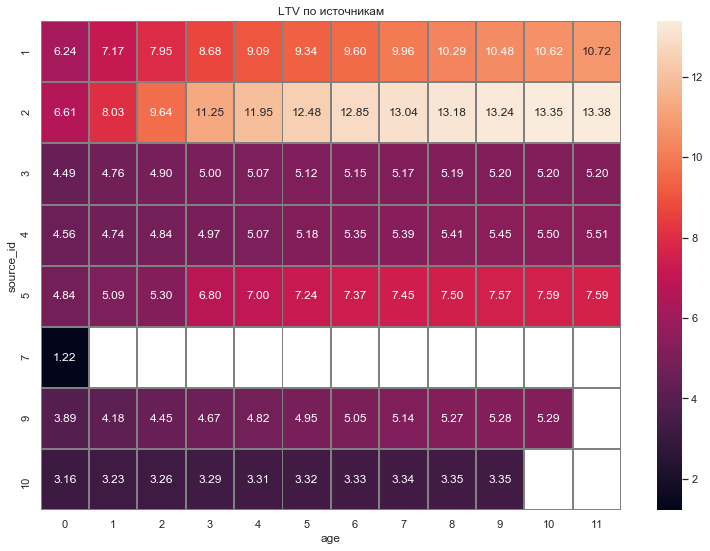

In [106]:
'''Строим тепловую карту LTV по источникам'''

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV по источникам')

sns.heatmap(buyers_costs_source_ltv_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray');

In [107]:
'''Считаем ROMI по источникам'''
daily_buyers_costs_month = daily_buyers_costs.groupby(['source_id', 'dt_month']).agg({'cac': 'mean'}).reset_index().rename(columns={'cac': 'cac_monthly', 'dt_month': 'first_order_month'})

In [108]:
daily_buyers_costs_month.head(10)

,source_id,first_order_month,cac_monthly
0,1,2017-06-01,7.98
1,1,2017-07-01,7.78
2,1,2017-08-01,9.95
3,1,2017-09-01,5.67
4,1,2017-10-01,6.08
5,1,2017-11-01,6.26
6,1,2017-12-01,6.19
7,1,2018-01-01,9.08
8,1,2018-02-01,8.48
9,1,2018-03-01,6.53


In [109]:
buyers_costs_source_ltv.head(10)

,source_id,buy_ts_month,first_order_month,revenue,cohort_source_size,age,ltv
0,1,2017-06-01,2017-06-01,"1,378.70",2899,0,0.48
1,1,2017-07-01,2017-06-01,414.98,2899,1,0.14
2,1,2017-07-01,2017-07-01,"1,166.70",2899,0,0.40
3,1,2017-08-01,2017-06-01,419.43,2899,2,0.14
4,1,2017-08-01,2017-07-01,175.31,2899,1,0.06
5,1,2017-08-01,2017-08-01,846.75,2899,0,0.29
6,1,2017-09-01,2017-06-01,714.24,2899,3,0.25
7,1,2017-09-01,2017-07-01,856.74,2899,2,0.30
8,1,2017-09-01,2017-08-01,135.29,2899,1,0.05
9,1,2017-09-01,2017-09-01,"1,365.34",2899,0,0.47


In [110]:
buyers_costs_source_romi = buyers_costs_source_ltv.merge(daily_buyers_costs_month, on=['source_id', 'first_order_month'], how='left')

In [111]:
buyers_costs_source_romi.head(10)

,source_id,buy_ts_month,first_order_month,revenue,cohort_source_size,age,ltv,cac_monthly
0,1,2017-06-01,2017-06-01,"1,378.70",2899,0,0.48,7.98
1,1,2017-07-01,2017-06-01,414.98,2899,1,0.14,7.98
2,1,2017-07-01,2017-07-01,"1,166.70",2899,0,0.40,7.78
3,1,2017-08-01,2017-06-01,419.43,2899,2,0.14,7.98
4,1,2017-08-01,2017-07-01,175.31,2899,1,0.06,7.78
5,1,2017-08-01,2017-08-01,846.75,2899,0,0.29,9.95
6,1,2017-09-01,2017-06-01,714.24,2899,3,0.25,7.98
7,1,2017-09-01,2017-07-01,856.74,2899,2,0.30,7.78
8,1,2017-09-01,2017-08-01,135.29,2899,1,0.05,9.95
9,1,2017-09-01,2017-09-01,"1,365.34",2899,0,0.47,5.67


### Общий вывод

Среднее количество посещений сайта пользователями с 01.06.2017 по 01.06.2018:

в день - 907

в неделю - 5716

в месяц - 23228

Регулярность пользования сайтом sticky_wau 15.87%, sticky_mau 3.90%

Количество посетителей сайта с августа 2017 года значительно выросло и достигло пика в ноябре и далее наблюдается снижение. Считаю, что нужно выяснить какие изменения в продукт были внесены в период роста и спада количества посетителей, был ли рост сезонным.

В среднем посетитель заходит на сайт один раз в день и проводит на сайте 1 минуту. 

В основном люди совершают покупку в момент первого визита на сайт.

На каждого покупателя в когорте приходится в среднем 1,39 покупок.

Из таблицы распределения пользователей по когортам видно, что почему-то все пользователи некоторых когорт, которые впервые зашли на сайт, в дальнейшем зашли только через месяц. Возможно сайт плохо работал или посетители редко вновь заходят.
Думаю необходимо сосредоточиться на данной метрике и постараться, чтобы посетители возвращались на сайт.

Средний уровень retention для когорт на втором месяце жизни когорты равен 6.1%

На втором месяце жизни когорты очень высокий churn rate (сильно меньше посетителей), затем количество пользователей, которые заходят на сайт из когорты немного увеличивается.

Количество заказов с каждой новой когортой увеличивается. Резко возросло количество заказов, начиная с октября 2017 года.

Среднее количество заказов покупателей разных когорт за 4 месяца - 4106 заказа

Всего потратили на привлечение клиетов за период с 1 июня 2017 года по 1 июня 2018 года 329 131.62 ден. ед.

Всего заработали денег за период с 1 июня 2017 года по 1 июня 2018 года 252 057.20 ден. ед.

Исходя из значений LTV и затрат на маркетинг можно сделать вывод, что бизнес убыточен.

Необходимо менять продукт и маркетинговую стратегию.

Больше всего потрачено денег привлечение посетителей из источника 3, меньше всего на источник 9. Траты на источник 4, 5 и 2 соизмеримы друг с другом.

Источники:

    3    141,321.63

    4    61,073.60

    5    51,757.10

    2    42,806.04

    1    20,833.27

    10   5,822.49

    9    5,517.49

Графики трат на каждый источник полностью повторяют графики количества привлеченных посетителей во времени.

Получается сколько денег потрачено столько посетителей и придет. Скорее всего основные траты это реклама (баннеры и т.д.).

Считаю необходимо развивать другие рекламные каналы кроме обычных. Например блог и социальные сети.

Наибольшие затраты в расчете на одного покупателя приходятся на источники 3 и 2, меньше всего на 9, 10. Получается самые выгодные источники - 9, 10.

По результатам расчета LTV по источникам получается самые выгодные источники привлечения - 1,2 и 4.

По результатам расчета ROMI по источникам получается самые выгодные источники привлечения - 1 и 4.

По результатам расчета LTV по устройствам получается, что пользователи, работающие на desktop приносят немного больше денег чем пользователи на touch.

По результатам расчета ROMI по устройствам получается, что необходимо сосредоточиться на источниках для desktop, а не touch. Пользователи, пришедшие из источников и устройства desktop окупаются на 2-й месяц, а пользователи на touch только на 6-й месяц.

Маркетологам можно посоветовать сосредоточиться на посетителях на desktop и источниках привлечения 1 и 4.